In [1]:
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
from audioUtilityFunctions import trim, apply_hann_window_fades
import numpy as np
import pytsmod as tsm
import crepe  
import soundfile as sf  
import librosa


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
median pitch: 72.92263114949637
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


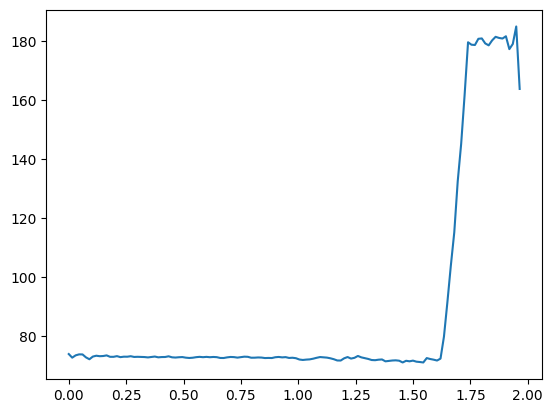

In [14]:
y, sr = librosa.load('./york_015_D2_sm57.wav')

f0_estimation_hop_length = 15  # step size in milliseconds

# Calculate tdpsola parameters based on CREPE settings
tdpsola_hop_size = int(sr * f0_estimation_hop_length / 1000)  # Convert ms to samples
tdpsola_win_size = int(1024 * (sr/16000) * 1.5)  # 1.5x larger window
# Get pitch estimation
time, f0, _, _ = crepe.predict(y, sr, viterbi=True, model_capacity='tiny', 
                              step_size=f0_estimation_hop_length)

plt.plot(time, f0)
medianPitch = np.median(f0)
print(f'median pitch: {medianPitch}') 

# Use calculated parameters in tdpsola
pitchedDown = tsm.tdpsola(y, sr, f0, tgt_f0=np.full_like(f0, medianPitch + 10), 
                         p_hop_size=tdpsola_hop_size, 
                         p_win_size=tdpsola_win_size)

time, f0_tuned, _, _ = crepe.predict(pitchedDown, sr, viterbi=True, 
                                    model_capacity='full', 
                                    step_size=f0_estimation_hop_length)

display(Audio(pitchedDown, rate=sr))
display(Audio(y, rate=sr))

(<Figure size 1200x400 with 2 Axes>, <Axes: xlabel='Time', ylabel='Hz'>)

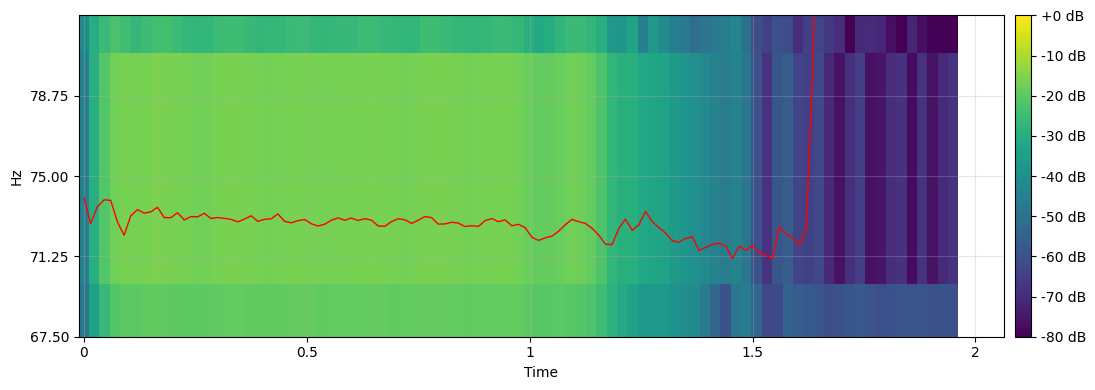

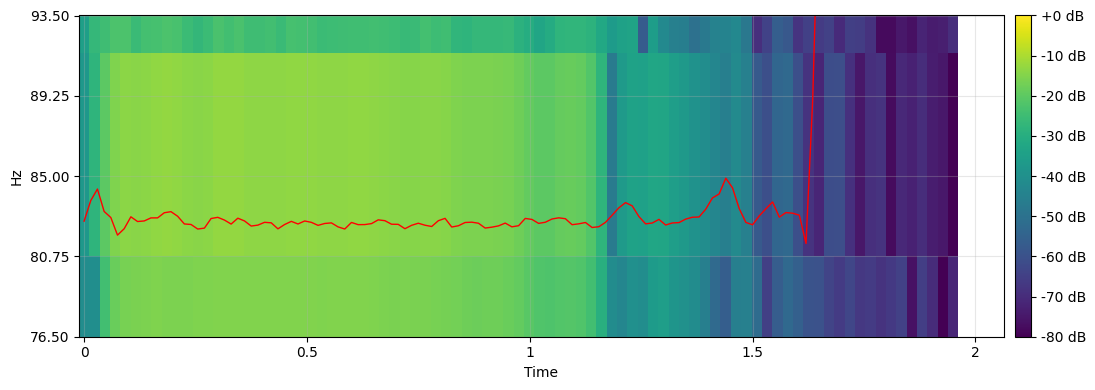

In [13]:
plot_pitch_estimation(y, sr, time, f0, freq_range=0.1, freq_focus=75)
plot_pitch_estimation(pitchedDown, sr, time, f0_tuned, freq_focus=85, freq_range=0.1)

### CONSTANTS

In [8]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load
N_FFT_MS = 200
HOP_LENGTH_MS = 1
FILE1 = 'samples/singlenotes/york/sm57/york_006_F1_sm57.wav'
# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4
pitch = librosa.note_to_hz('F1')


In [ ]:
y, sr = librosa.load(FILE1,sr=SAMPLE_RATE)
print(f"File 1: {FILE1}")
display(Audio(data=y, rate=sr))

### CREPE PITCH ESTIMATION PLOTTING

In [5]:
def plot_pitch_estimation(y, sr, time, f0, freq_focus=100, freq_range=0.5):
    """
    Plot spectrogram with F0 overlay
    
    Parameters:
    y : audio signal
    sr : sample rate
    time : time points from CREPE
    f0 : frequency values from CREPE
    freq_focus : center frequency for y-axis range
    freq_range : range around freq_focus (as proportion)
    """
    y_min = freq_focus * (1 - freq_range)
    y_max = freq_focus * (1 + freq_range)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Calculate and display spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(
        D, 
        y_axis='hz', 
        x_axis='time',
        sr=sr,
        ax=ax,
        vmin=-80,
        vmax=0,
        cmap='viridis'
    )
    
    # Plot F0 line
    ax.plot(time, f0, color='r', linewidth=1, alpha=1.0, label='f0')
    
    # Set y-axis limits and grid
    ax.set_ylim(y_min, y_max)
    tick_spacing = freq_focus * 0.05
    yticks = np.arange(y_min, y_max, tick_spacing)
    ax.set_yticks(yticks)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    fig.colorbar(img, format='%+2.0f dB', pad=0.01)
    plt.tight_layout()
    return fig, ax

### PITCH ESTIMATION PLOTTING

In [34]:
def plot_pitch_estimation(y, sr, f0, f0_estimation_hop_length, viz_frame_length, viz_hop_length, freq_focus, freq_range=0.5):
    if viz_hop_length is None:
        viz_hop_length = viz_frame_length // 4
    
    
    y_min = freq_focus * (1 - freq_range)
    y_max = freq_focus * (1 + freq_range)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y, n_fft=viz_frame_length, hop_length=viz_hop_length)), 
        ref=np.max
    )
    img = librosa.display.specshow(
        D, y_axis='hz', x_axis='time', 
        ax=ax, vmin=-80, vmax=0,
        hop_length=viz_hop_length,
        sr=sr,
        cmap='viridis'
    )
    
    times = librosa.times_like(f0, sr=sr, hop_length=f0_estimation_hop_length)
    ax.plot(times, f0, color='r', linewidth=1, alpha=1.0, label='f0')
    
    ymin, ymax = 0, 200
    ax.set_ylim(y_min, y_max)
    tick_spacing = freq_focus * 0.05
    yticks = np.arange(y_min, y_max, tick_spacing)
    ax.set_yticks(yticks)
    ax.grid(True, alpha=0.3)
    
    fig.colorbar(img, format='%+2.0f dB', pad=0.01)
    plt.tight_layout()
    return fig, ax


### Get Pitch Estimation


In [ ]:
# F0 params
pitchRange = pitch

# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4

# Extract F0 with explicit parameters
f0, unused, unused, = librosa.pyin(
    y, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=pitchRange*0.7,
    fmax=pitchRange*1.3 
)

print(f0)

# Visualization of y
plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=pitch
)
plt.title(f"{FILE1}")

### Autotune with TD-PSOLA python

In [ ]:
target_pitch = pitch
target_pitch_array = np.full_like(f0, target_pitch)
tuned = psola.vocode(y, sr, target_pitch=target_pitch_array, fmin=20, fmax=600)

# Extract F0 with explicit parameters
tuned_f0, unused, unused = librosa.pyin(
    tuned, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=target_pitch*0.7,
    fmax=target_pitch*1.3 )

plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=target_pitch
)

# Visualization
plot_pitch_estimation(
    tuned, sr, tuned_f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=target_pitch
)

plt.title('Auto-tuned')

print("original audio:")
display(Audio(y, rate=sr))
print("auto-tuned audio:")
display(Audio(tuned, rate=sr))